In [1]:
import rioxarray as rxr
import xarray as xr
import numpy as np
import pandas as pd
import codebase
import matplotlib.pyplot as plt

# Parameters

In [2]:
dam_name = 'glen canyon'
reproj_crs_code = 54017

# Load data

## Load reservoir shapes

In [3]:
res_shp = codebase.load_data.load_GRanD()

In [4]:
subset_gpd = codebase.area_subsets.check_for_multiple_dams(dam_name,res_shp)
subset_bbox = subset_gpd.geometry.buffer(0).bounds
subset_bbox

,minx,miny,maxx,maxy
596,-111.570835,36.937778,-111.221875,37.105153


## Load DEM data

In [5]:
dem_filepath = '/global/scratch/users/ann_scheliga/aux_dam_datasets/'
dem_filename = 'n30w120_dem.tif'
DEM = codebase.load_data.load_DEM_subset_as_rxrDA(subset_bbox,dem_filepath,dem_filename)

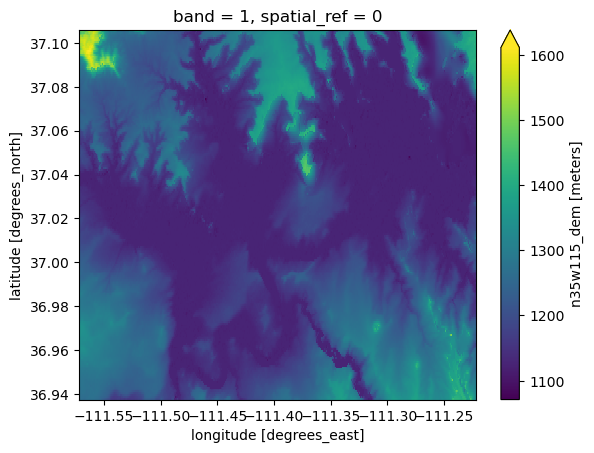

In [6]:
## Data Processing

# Adding metadata
DEM = DEM.assign_attrs(name = 'Elevation',units='meters',comments = 'referenced to WGS84 EGM96 geoid')
DEM = DEM.rename('Elevation') # name is necessary to merge into a dataset
DEM_masked = DEM.where(DEM != 32767).squeeze() # fill value = 32767
DEM_masked.plot(cbar_kwargs={'extend':'max'})

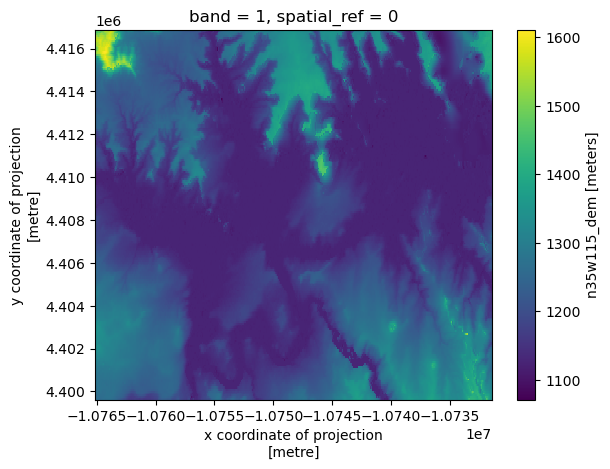

In [7]:
DEM_reproj = codebase.area_calcs.project_DA_from_crs_code(DEM_masked,reproj_crs_code)
DEM_reproj.plot()

In [8]:
DEM_reproj.shape

(212, 415)

## Load CYGNSS data

In [9]:
fw_latlon = codebase.load_data.load_CYGNSS_001_all_months(subset_bbox)
fw_binary = codebase.area_calcs.cygnss_convert_to_binary(fw_latlon)
fw_reproj = codebase.area_calcs.project_DA_from_crs_code(fw_binary,reproj_crs_code)

# Data merge
DEM and CYGNSS data into a single xr.DataSet

In [10]:
fw_res_match = fw_reproj.rio.reproject_match(DEM_reproj)

In [11]:
combo_ds = xr.merge([fw_res_match,DEM_reproj])
combo_ds

<xarray.Dataset>
Dimensions:      (time: 57, x: 415, y: 212)
Coordinates:
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9 ... 48 49 50 51 52 53 54 55 56
    spatial_ref  int64 0
  * x            (x) float64 -1.077e+07 -1.077e+07 ... -1.073e+07 -1.073e+07
  * y            (y) float64 4.417e+06 4.417e+06 4.417e+06 ... 4.4e+06 4.4e+06
    band         int64 1
Data variables:
    Watermask    (time, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    Elevation    (y, x) float32 1.452e+03 1.47e+03 ... 1.34e+03 1.326e+03
Attributes:
    units:     Binary mask of surface water
    comments:  Surface water = 1, ocean/land/no data = 0

In [12]:
# 1) Groupby elevation integer.
# 2) Get the fraction of each group that is inundated.
# 3) Plot of elevation int vs. fraction inundated.

In [32]:
min_elev = combo_ds['Elevation'].min()
max_elev = combo_ds['Elevation'].max()
elev_bins = np.arange(min_elev,max_elev,1)

## Groupby through xarray
Kinda confusing, trying out using pd.groupby

In [33]:
test_groupby = combo_ds.groupby_bins('Elevation',bins=elev_bins).mean()
test_groupby

<xarray.Dataset>
Dimensions:         (time: 57, Elevation_bins: 539)
Coordinates:
  * time            (time) int64 0 1 2 3 4 5 6 7 8 ... 49 50 51 52 53 54 55 56
  * Elevation_bins  (Elevation_bins) object (1071.0, 1072.0] ... (1609.0, 161...
    spatial_ref     int64 0
    band            int64 1
Data variables:
    Watermask       (Elevation_bins, time) float64 nan nan nan ... 0.0 0.0 0.0
    Elevation       (Elevation_bins) float32 nan nan nan ... nan nan 1.61e+03
Attributes:
    units:     Binary mask of surface water
    comments:  Surface water = 1, ocean/land/no data = 0

## Groupby as pd.DataFrame (all time steps)
We'll see how this works

In [34]:
combo_df = combo_ds.to_dataframe()
combo_df.reset_index(drop=True,inplace=True)

In [35]:
elev_stats = combo_df.groupby(pd.cut(combo_df['Elevation'], elev_bins),observed=True)['Watermask'].mean()

In [36]:
elev_bin_mids = elev_stats.index.map(lambda x: x.mid)

Text(0.5, 1.0, 'Frequency of inundation across all time of Lake Powell')

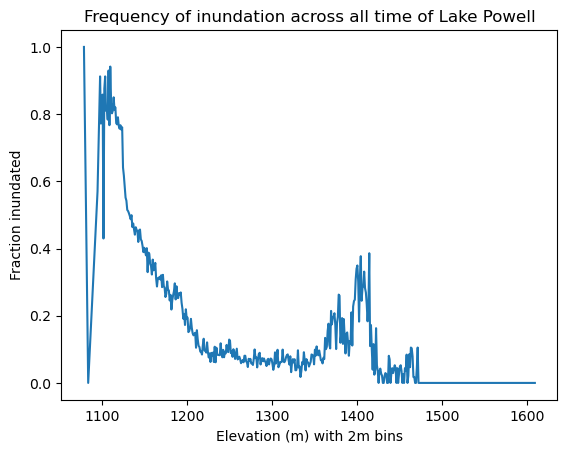

In [37]:
plt.plot(elev_bin_mids,elev_stats)
plt.ylabel('Fraction inundated')
plt.xlabel('Elevation (m) with 2m bins')
plt.title('Frequency of inundation across all time of Lake Powell')

## Groupby as pd.DataFrame (individual time steps)

In [38]:
combo_df = combo_ds.to_dataframe()
combo_df.reset_index(inplace=True)
combo_df.head(2)

,time,x,y,spatial_ref,Watermask,band,Elevation
0,0,-1.076509e+07,4.416826e+06,0,0,1,1452.0
1,0,-1.076509e+07,4.416745e+06,0,0,1,1453.0


In [39]:
elev_time_stats = combo_df.groupby(['time',pd.cut(combo_df['Elevation'], elev_bins)],observed=True)['Watermask'].agg(['mean','count'])
elev_time_stats

mean  count
time Elevation                    
0    (1078.0, 1079.0]   1.0      1
     (1083.0, 1084.0]   0.0      2
     (1094.0, 1095.0]   0.5      2
     (1097.0, 1098.0]   1.0      1
     (1098.0, 1099.0]   1.0      8
...                     ...    ...
56   (1599.0, 1600.0]   0.0      2
     (1601.0, 1602.0]   0.0      1
     (1603.0, 1604.0]   0.0      1
     (1605.0, 1606.0]   0.0      2
     (1609.0, 1610.0]   0.0      1

[28386 rows x 2 columns]

In [40]:
elev_bin_mids = elev_time_stats.index.get_level_values('Elevation').map(lambda x: x.mid)
elev_bin_mids_unique = elev_bin_mids.astype(float).unique()

Text(0.5, 1.0, 'Inundation by elevation of Lake Powell at timestep = 5')

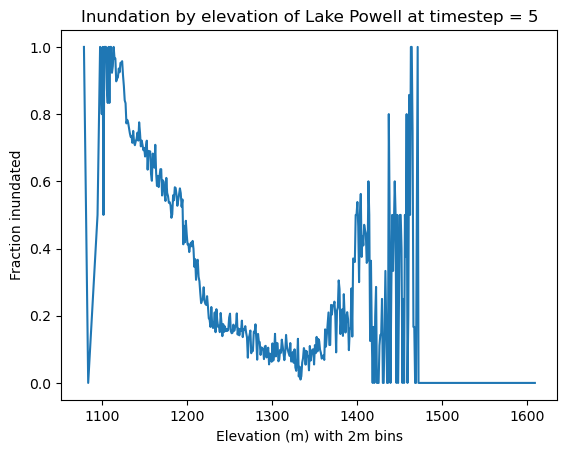

In [41]:
timestep = 5

plt.plot(elev_bin_mids_unique,elev_time_stats.loc[timestep,'mean'])
plt.ylabel('Fraction inundated')
plt.xlabel('Elevation (m) with 2m bins')
plt.title('Inundation by elevation of Lake Powell at timestep = '+str(timestep))

## Plot elevation vs. cumulative area
1) get area of each elevation bin
2) multiply area of each bin by fraction inundated

Note: the conditioned DEM shows most pixels at one singular elevation. Will identify this mode value.

Text(0.5, 1.0, 'Pixel count by elevation of Lake Powell at timestep = 50')

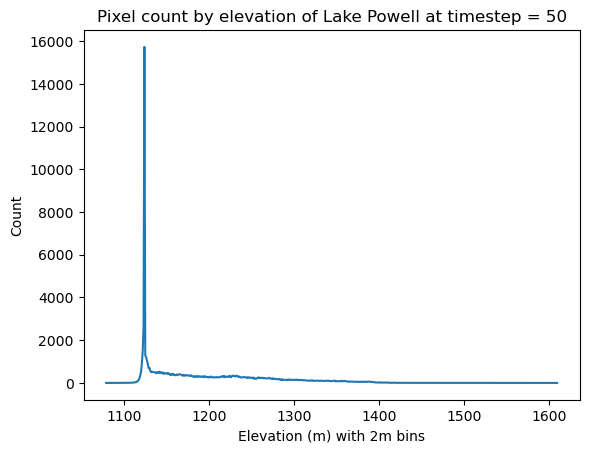

In [42]:
timestep = 50
plt.plot(elev_bin_mids_unique,elev_time_stats.loc[timestep,'count'])
plt.ylabel('Count')
plt.xlabel('Elevation (m) with 2m bins')
plt.title('Pixel count by elevation of Lake Powell at timestep = '+str(timestep))

In [43]:
for timestep in np.arange(57):
    mode_elev = elev_time_stats.loc[timestep,'count'].idxmax()
    print(timestep,mode_elev, elev_time_stats.loc[(timestep,mode_elev),'count'])

0 (1123.0, 1124.0] 15726
1 (1123.0, 1124.0] 15726
2 (1123.0, 1124.0] 15726
3 (1123.0, 1124.0] 15726
4 (1123.0, 1124.0] 15726
5 (1123.0, 1124.0] 15726
6 (1123.0, 1124.0] 15726
7 (1123.0, 1124.0] 15726
8 (1123.0, 1124.0] 15726
9 (1123.0, 1124.0] 15726
10 (1123.0, 1124.0] 15726
11 (1123.0, 1124.0] 15726
12 (1123.0, 1124.0] 15726
13 (1123.0, 1124.0] 15726
14 (1123.0, 1124.0] 15726
15 (1123.0, 1124.0] 15726
16 (1123.0, 1124.0] 15726
17 (1123.0, 1124.0] 15726
18 (1123.0, 1124.0] 15726
19 (1123.0, 1124.0] 15726
20 (1123.0, 1124.0] 15726
21 (1123.0, 1124.0] 15726
22 (1123.0, 1124.0] 15726
23 (1123.0, 1124.0] 15726
24 (1123.0, 1124.0] 15726
25 (1123.0, 1124.0] 15726
26 (1123.0, 1124.0] 15726
27 (1123.0, 1124.0] 15726
28 (1123.0, 1124.0] 15726
29 (1123.0, 1124.0] 15726
30 (1123.0, 1124.0] 15726
31 (1123.0, 1124.0] 15726
32 (1123.0, 1124.0] 15726
33 (1123.0, 1124.0] 15726
34 (1123.0, 1124.0] 15726
35 (1123.0, 1124.0] 15726
36 (1123.0, 1124.0] 15726
37 (1123.0, 1124.0] 15726
38 (1123.0, 1124.0] 15